# AdaptiveTracking_2021

- **Paper**: An Adaptive Tracking Algorithm for Convection in Simulated and Remote Sensing Data

- $\textbf{\textcolor{red}{Identification}}$:
    - **Identification**: no new technique

    - **Representation**: estimate by Ellipse with geometric mean centroid instead of weighted mean.

- $\textbf{\textcolor{blue}{Tracking}}$:
    - **Flow region**: a squared area around each storm 
        $$side = object \ length + buffer$$
        After searching, we gain an estimated vector.

    - **Corrected shift**: uses both *estimated shift* vs *recorded motion*:
        + If 2 differs too much $\Rightarrow$ use *recorded motion*.
        + If not, take the mean of them.

    - **Search region**: the predicted window of the current storm.

    - **Candidates**: storms which are partially or entirely located in search region.

    - **Disparity matrix**: cost between candidate-target, disparity $D$ has 2 elements:
            $$D = d_c + d_p + \sqrt{a_c} - \sqrt{a_0}$$
        + $d_c = \operatorname{dist(cand\_center, targ\_center)}$
        + $d_p = \operatorname{dist(cand\_center, pred\_center)}$
        + $a_c$ = area difference between 2 storms
        + $a_o$ = area overlapping between 2 storms.
        
    - **Hungarian matching**: 
        + assign 1-to-1 mapping
        + after assignment, check if D>=45km/hr => cancel
        + not matched prev storm => expired
        + not matched curr storm => initiated

    - **Split & merge**:
        + *split*: new storm ovelaps with prev obj. The obj with least disparity carries the UID of the parent.
        + *merge*: expired storm overlaps with current storm. The resulting storm receives the UID of the previous matching storm.

- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + Not mentioned, hence applied the linear interpolation as the previous.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [ ]:
# from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
# from tqdm.notebook import tqdm

# data_name = "KGRR"

# SOURCE_PATH = f"data/numpy_grid/{data_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
# ]

# print(f"-" * 20)

# dbz_maps = []

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     img = read_numpy_grid(path)
#     dbz_map = nexrad_numpy_preprocessing_pipeline(img)
#     dbz_maps.append(np.nan_to_num(dbz_map))

# dbz_map_sample = dbz_maps[0]
# img_shape = (dbz_map_sample.shape[0], dbz_map_sample.shape[1], 3)
# print(f"Image shape: {img_shape}")

# print(f"Number of frames: {len(dbz_maps)}")

--------------------


Processing images and detecting storms:   0%|          | 0/31 [00:00<?, ?it/s]

Image shape: (901, 901, 3)
Number of frames: 31


In [141]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

data_name = "philippines_13.269_123.832"
SOURCE_PATH = f"data/image_old/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]
img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]

Number of frames: 50


## 1. Identification

- Implement class `CentroidStorm` which stores the information about its contour shape, and its centroid.

In [142]:
from src.identification import MorphContourIdentifier, HypothesisIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely.geometry import Polygon
from skimage.registration import phase_cross_correlation

class CentroidStorm(StormObject):
    centroid: np.ndarray
    estimated_velocity: tuple[float, float] = None  # estimated velocity for the current storm in the next frame

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], id: str=""):
        super().__init__(polygon, id)
        self.centroid = np.array(centroid).astype(np.int64)

class DbzStormsMap(StormsMap):
    storms: list[CentroidStorm]
    dbz_map: np.ndarray

    def __init__(
            self, storms: list[CentroidStorm], time_frame: datetime, dbz_map: np.ndarray
        ) -> list[tuple[int, int, int, int]]:
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map
    
    def fft_estimate(self, next_storms_map: "DbzStormsMap", max_velocity: float, buffer: int=24) -> list[tuple[int, int, int, int]]:
        """
        Estimate the movement for each storm in the current map.
        Return the square, surrounding regions without buffer for each storm.

        --------
        Args:
            next_storms_map (DbzStormsMap): the next storms map.
            max_velocity (float): maximum allowed velocity (pixels/hour) for truncation.
        
        -------
        Returns:
            region_list (list[min_y, max_y, min_x, max_x]): regions for each storm without the buffer.
        """
        H, W = self.dbz_map.shape

        dbz_map_1 = self.dbz_map
        dbz_map_2 = next_storms_map.dbz_map

        dt = (next_storms_map.time_frame - self.time_frame).total_seconds() / 3600.0    # in hours
        max_displacement = max_velocity * dt
        # buffer = int(max_displacement) + 5          # compute the buffer

        region_list = []

        for storm in self.storms:
            min_x, min_y, max_x, max_y = storm.contour.bounds
            y_len = max_y - min_y
            x_len = max_x - min_x
            if y_len < x_len:
                min_y = max(min_y - ((x_len - y_len) // 2), 0)
                max_y = min(max_y + ((x_len - y_len) // 2), H)
                min_x = max(min_x, 0)
                max_x = min(max_x, W)
            else:
                min_x = max(min_x - ((y_len - x_len) // 2), 0)
                max_x = min(max_x + ((y_len - x_len) // 2), W)
                min_y = max(min_y, 0)
                max_y = min(max_y, H)

            # store the region without buffer
            region_list.append((min_y, max_y, min_x, max_x))

            # add buffer to the search region
            min_x = max(min_x - buffer, 0)
            max_x = min(max_x + buffer, W)
            min_y = max(min_y - buffer, 0)
            max_y = min(max_y + buffer, H)

            # get the search regions
            prev_region = dbz_map_1[int(min_y):int(max_y), int(min_x):int(max_x)]
            curr_region = dbz_map_2[int(min_y):int(max_y), int(min_x):int(max_x)]

            # normalize regions
            prev_region = prev_region - np.mean(prev_region)
            curr_region = curr_region - np.mean(curr_region)

            # compute shift via FFT
            shift, _, _ = phase_cross_correlation(curr_region, prev_region, upsample_factor=16)
            dy, dx = shift

            # truncate the large shift
            shift_magnitude = np.linalg.norm(shift)
            if shift_magnitude > max_displacement:
                scale_factor = max_displacement / shift_magnitude
                dy *= scale_factor
                dx *= scale_factor

            storm.estimated_velocity = (dy / dt, dx / dt)  # in pixels / hour

        return region_list

In [143]:
THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10
DENSITY = 0.05           # number of particles of a storm = area * DENSITY

Processing images and detecting storms: 100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 14
Time: 2025-01-08 03:16:44 | Detected storms: 23
Time: 2025-01-08 03:22:45 | Detected storms: 19
Time: 2025-01-08 03:28:45 | Detected storms: 15
Time: 2025-01-08 03:34:45 | Detected storms: 12
Time: 2025-01-08 03:40:45 | Detected storms: 14
Time: 2025-01-08 03:46:46 | Detected storms: 22
Time: 2025-01-08 03:52:46 | Detected storms: 26
Time: 2025-01-08 03:58:46 | Detected storms: 15
Time: 2025-01-08 04:04:46 | Detected storms: 14
Time: 2025-01-08 04:10:47 | Detected storms: 17
Time: 2025-01-08 04:16:47 | Detected storms: 17
Time: 2025-01-08 04:22:47 | Detected storms: 22
Time: 2025-01-08 04:28:47 | Detected storms: 19
Time: 2025-01-08 04:34:48 | Detected storms: 21
Time: 2025-01-08 04:40:48 | Detected storms: 16
Time: 2025-01-08 04:46:48 | Detected storms: 12
Time: 2025-01-08 04:52:48 | Detected storms: 18
Time: 2025-01-08 04:58:49 | Detected storms: 15
Time: 2025-01-08 05:04:49 | Detected storms: 16
Time: 2025-01-08 05

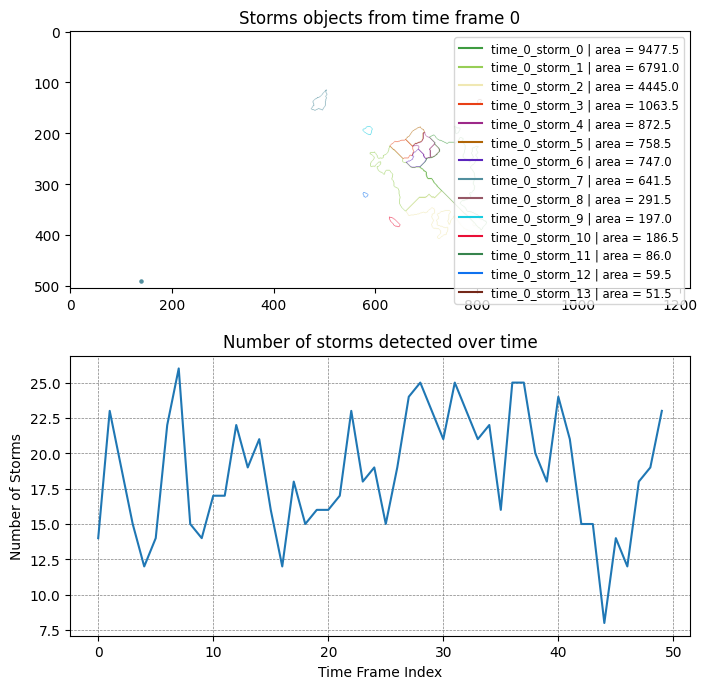

In [145]:
# identifier = MorphContourIdentifier(n_thresh=3, threshold=THRESHOLD, filter_area=FILTER_AREA)
identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    # time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute the geometric centroid instead of weighted centroid
        centroid = np.array([polygon.centroid.y, polygon.centroid.x])

        storms.append(CentroidStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}"
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    # x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    x_centroid, y_centroid = storm.centroid
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')
plt.legend(loc="upper right", fontsize='small', ncol=1)


plt.subplot(2,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

Time difference between frames: 0.10 hours
Estimated movement for storm time_0_storm_0: dy = 0.19, dx = -2.38 (pixels)


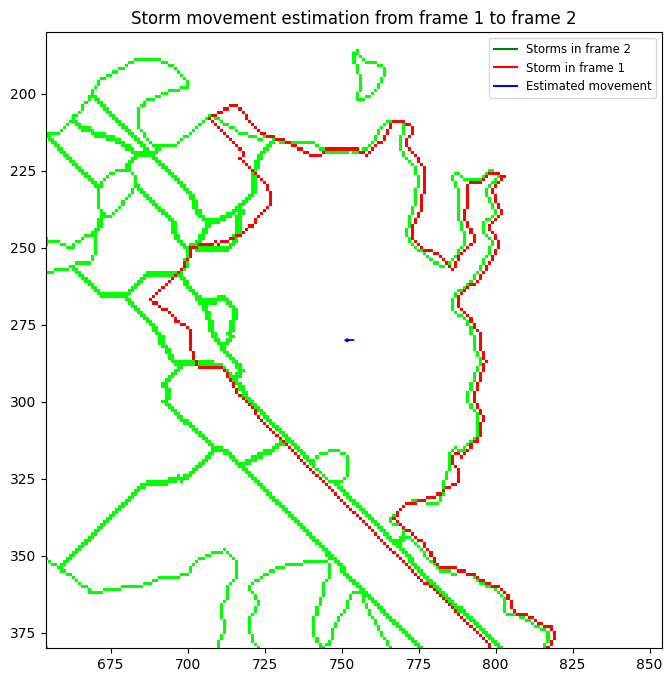

In [146]:
## Test for matching via FFT-based estimation
MAX_VELOCITY = 100

prev_storms_map = storms_map_time_lst[0]
curr_storms_map = storms_map_time_lst[1]

dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0  # in hours

print(f"Time difference between frames: {dt:.2f} hours")

search_region_list = prev_storms_map.fft_estimate(curr_storms_map, max_velocity=MAX_VELOCITY)

# plot storms in the 2nd frame
plt.figure(figsize=(8, 8))
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

curr_storms_contours = convert_polygons_to_contours([storm.contour for storm \
                                                     in curr_storms_map.storms])
cv2.drawContours(blank_image, curr_storms_contours, -1, (0, 255, 0), thickness=1)
plt.plot([], [], color='green', label='Storms in frame 2')

# plot a storm in 1st frame and its estimated movement
storm_idx = 0
prev_storm = prev_storms_map.storms[storm_idx]
vy, vx = prev_storm.estimated_velocity      # in pixels / hour
dy = vy * dt
dx = vx * dt

print(f"Estimated movement for storm {prev_storm.id}: dy = {dy:.2f}, dx = {dx:.2f} (pixels)")

centroid_y, centroid_x = prev_storm.centroid

cv2.drawContours(blank_image, convert_polygons_to_contours([prev_storm.contour]), \
                 -1, (255, 0, 0), thickness=1)
plt.plot([], [], color='red', label='Storm in frame 1')

plt.arrow(int(centroid_x), int(centroid_y), int(dx), int(dy), color='blue', \
          head_width=1, head_length=1)
plt.plot([], [], color='blue', label='Estimated movement')

plt.legend(loc="upper right", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")

plt.title('Storm movement estimation from frame 1 to frame 2')
plt.xlim(centroid_x - 100, centroid_x + 100)
plt.ylim(centroid_y + 100, centroid_y - 100)

plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Disparity matrix**: cost between candidate-target, $D$ has 2 elements:
        $$D = d_c + d_p + \sqrt{a_c} - \sqrt{a_0}$$
    + $d_c = \operatorname{dist(cand\_center, \ targ\_center)}$
    + $d_p = \operatorname{dist(cand\_center, \ pred\_center)}$
    + $a_c$ = area difference between 2 storms
    + $a_o$ = area overlapping between 2 storms.

In [147]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker
from typing import Callable
from shapely.affinity import translate
from shapely.geometry import box

class Matcher(BaseMatcher):
    max_velocity: float
    max_velocity_diff: float    # to resolve estimated shift vs. historical motion

    def __init__(self, max_velocity: float, max_velocity_diff: float):
        self.max_velocity = max_velocity            # maximum allowed velocity (pixels/hour) for truncation
        self.max_velocity_diff = max_velocity_diff  # maximum difference between historical and estimated velocity
        # self.max_cost = max_cost                    # maximum cost for cost matrix

    def _construct_disparity_matrix(
            self, storm_lst1: list[CentroidStorm], storm_lst2: list[CentroidStorm], 
            shifts: np.ndarray
        ) -> np.ndarray:
        """
        Construct a disparity matrix based on centroids estimated from FFT.

        Args:
            storm_lst1 (list[CentroidStorm]): List of storms in previous time (target of matching).
            storm_lst2 (list[CentroidStorm]): List of storms in current time (candidate for matching).
            estimated_displacements (list[np.ndarray]): Estimated displacements for each storm in storm_lst1.
        
        Returns:
            np.ndarray: Disparity matrix.
        """
        targ_centroids = np.array([storm.centroid for storm in storm_lst1])
        cand_centroids = np.array([storm.centroid for storm in storm_lst2])
        pred_center = targ_centroids + shifts

        d_c = np.linalg.norm(
            targ_centroids[:, np.newaxis, :] - cand_centroids[np.newaxis, :, :], axis=-1
        )   # shape: (num_targ, num_cand)
        
        d_p = np.linalg.norm(
            pred_center[:, np.newaxis, :] - cand_centroids[np.newaxis, :, :], axis=-1
        )   # shape: (num_targ, num_cand)
        
        a_c = np.abs(
            np.array([storm.contour.area for storm in storm_lst1])[:, np.newaxis] - 
            np.array([storm.contour.area for storm in storm_lst2])[np.newaxis, :]
        )   # shape: (num_targ, num_cand)

        a_o = np.array([
            prev_storm.contour.intersection(curr_storm.contour).area
            for prev_storm in storm_lst1
            for curr_storm in storm_lst2
        ]).reshape(len(storm_lst1), len(storm_lst2))

        return np.clip(d_c + d_p + np.sqrt(a_c) - np.sqrt(a_o), 0, None)
    
    def _process_velocity(self, history_velocity: np.ndarray, estimated_velocity: np.ndarray) -> np.ndarray:
        """
        Process the velocity by combining historical and estimated velocities of a storm.

        Args:
            history_velocity (np.ndarray): Historical velocity of the storm.
            estimated_velocity (np.ndarray): Estimated velocity from FFT.

        Returns:
            np.ndarray: corrected velocity.
        """
        # case 1: no history recorded => use estimated velocity
        if history_velocity is None:
            return estimated_velocity
        # case 2: 2 vecttors differ too much => use history velocity
        elif np.linalg.norm(history_velocity - estimated_velocity) > self.max_velocity_diff:
            return history_velocity
        # case 3: 2 vectors do not differ too much => average both
        else:
            return 0.5 * (history_velocity + estimated_velocity)

    def match_storms(
            self, storms_map_1: DbzStormsMap, storms_map_2: DbzStormsMap, history_velocities: list[np.ndarray]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Match storms between 2 time frames.

        Args:
            storms_map_1 (DbzStormsMap): Previous storms map.
            storms_map_2 (DbzStormsMap): Current storms map.
            history_velocities (list[np.ndarray]): Previously recorded velocities for storms in storms_map_1.
        
        Returns:
            tuple[np.ndarray, np.ndarray, np.ndarray]: 
                + matched indices (N x 2) where N is the number of matched storm pairs.
                + cost matrix (num_storms_1 x num_storms_2).
                + corrected shifts (num_storms_1 x 2).
                
        """
        # region_list (list[min_y, min_x, max_y, max_x]): regions for each storm without the buffer
        region_list = storms_map_1.fft_estimate(storms_map_2, max_velocity=self.max_velocity)
        dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0  # in hours
        # max_displacement = self.max_velocity * dt

        # Step 1: Retrieve displacements
        estimated_velocities = [
            np.array(storm.estimated_velocity) for storm in storms_map_1.storms
        ]

        corrected_shifts = np.array([
            self._process_velocity(history_velocity, estimated_velocity) * dt
            for history_velocity, estimated_velocity in zip(history_velocities, estimated_velocities)
        ])

        # step 2: Retrieve search regions = original regions + corrected shifts
        H, W = storms_map_1.dbz_map.shape
        regions = np.array(region_list)
        y_regions = regions[:, :2]
        x_regions = regions[:, 2:]
        y_search_regions = np.clip(y_regions + corrected_shifts[:, 0][:, np.newaxis], 0, H)
        x_search_regions = np.clip(x_regions + corrected_shifts[:, 1][:, np.newaxis], 0, W)

        search_regions = np.concatenate([y_search_regions, x_search_regions], axis=-1)

        # Step 3: Construct disparity matrix
        cost_matrix = self._construct_disparity_matrix(
            storms_map_1.storms,
            storms_map_2.storms,
            corrected_shifts
        )

        # step 4: Mark the valid matches => curr storm in the search region of previous storm
        valid_mask = np.zeros_like(cost_matrix, dtype=bool)

        for i in range(len(storms_map_1.storms)):
            min_y, max_y, min_x, max_x = search_regions[i]
            search_box = box(min_x, min_y, max_x, max_y)
            for j, storm in enumerate(storms_map_2.storms):
                curr_pol = storm.contour
                # intersect a part or whole => valid
                if search_box.intersection(curr_pol).area > 0:
                    valid_mask[i, j] = True

        # step 5: Invalidate the invalid matches
        invalid_mask = ~valid_mask
        cost_matrix[invalid_mask] = 5000.0   # large cost for invalid matches

        # step 6: Find the optimal matching
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & valid_mask), cost_matrix, corrected_shifts

Prev storm 1. Estimated shift: dy = -0.12 pixels, dx = -0.44 pixels


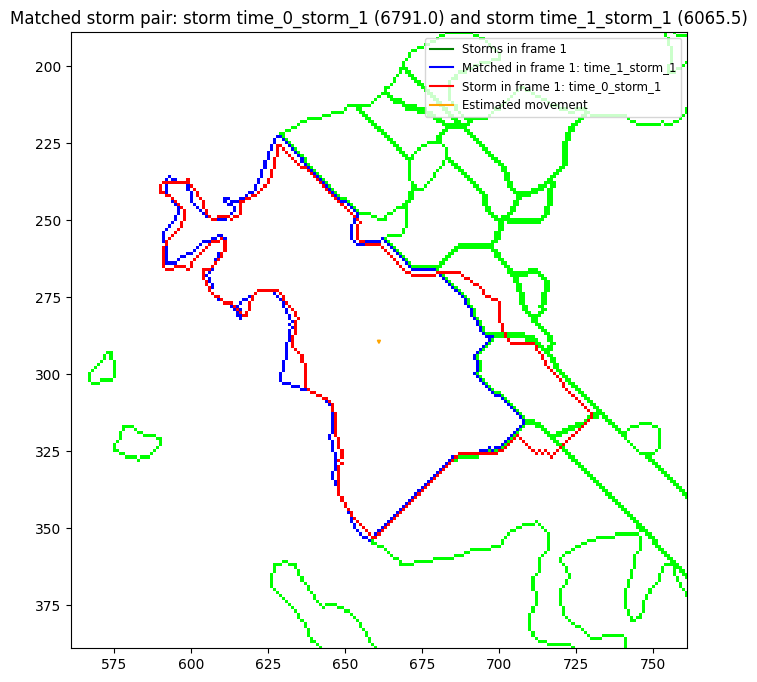

In [148]:
MAX_VELOCITY = 100          # in km/h
MAX_VELOCITY_DIFF = 20.0    # maximum difference between historical and estimated velocity
MATCHING_THRESHOLD = 0.5    # minimum probability threshold for matching between 2 storms

matcher = Matcher(max_velocity=MAX_VELOCITY, max_velocity_diff=MAX_VELOCITY_DIFF)

prev_idx, curr_idx = 0, 1
storms_map_1 = storms_map_time_lst[prev_idx]
storms_map_2 = storms_map_time_lst[curr_idx]

dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0

assignments, cost_matrix, corrected_shifts = matcher.match_storms(
    storms_map_1=storms_map_1, storms_map_2=storms_map_2, history_velocities=[None] * len(storms_map_1.storms)
)

# visualize a matched pair
prev_idx, curr_idx = assignments[1]

prev_storm = storms_map_1.storms[prev_idx]

dy, dx = corrected_shifts[prev_idx]

print(f"Prev storm {prev_idx}. Estimated shift: dy = {dy:.2f} pixels, dx = {dx:.2f} pixels")

plt.figure(figsize=(8, 8))
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# plot storms in the 2nd frame
## all storms
curr_contours = convert_polygons_to_contours([storm.contour for storm \
                                                     in storms_map_2.storms])
cv2.drawContours(blank_image, curr_contours, -1, (0, 255, 0), thickness=1)
plt.plot([], [], color='green', label=f'Storms in frame {curr_idx}')

## only matched storm
curr_storm = storms_map_2.storms[curr_idx]
contours = convert_polygons_to_contours([curr_storm.contour])
cv2.drawContours(blank_image, contours, -1, (0, 0, 255), thickness=1)
plt.plot([], [], color='blue', label=f'Matched in frame {curr_idx}: {curr_storm.id}')

# plot prev_storm
contours = convert_polygons_to_contours([prev_storm.contour])
centroid_y, centroid_x = prev_storm.centroid
cv2.drawContours(blank_image, contours, -1, (255, 0, 0), thickness=1)
plt.plot([], [], color='red', label=f'Storm in frame {prev_idx}: {prev_storm.id}')
plt.arrow(int(centroid_x), int(centroid_y), int(dx), int(dy), color='orange', \
          head_width=1, head_length=1)
plt.plot([], [], color='orange', label='Estimated movement')

plt.imshow(blank_image,cmap="grey")
plt.legend(loc="upper right", fontsize='small', ncol=1)

plt.title(f'Matched storm pair: storm {prev_storm.id} ({prev_storm.contour.area}) and storm {curr_storm.id} ({curr_storm.contour.area})')
plt.xlim(centroid_x - 100, centroid_x + 100)
plt.ylim(centroid_y + 100, centroid_y - 100)
plt.show()

In [149]:
import pandas as pd

# compute d_p, d_c, a_c, a_o for between storm prev_idx and all curr storms
prev_idx = 1
prev_storm = storms_map_1.storms[prev_idx]

pred_center = prev_storm.centroid + np.array(prev_storm.estimated_velocity) * dt

print(f"Storm {prev_storm.id}: area = {prev_storm.contour.area}, centroid = {prev_storm.centroid}, predicted centroid = {pred_center}")

d_p, d_c, a_c, a_o, costs = [], [], [], [], []
curr_centroid_lists, curr_area_list = [], []

for curr_storm in storms_map_2.storms:
    # centroid and area of curr storm
    curr_centroid_lists.append(curr_storm.centroid)
    curr_area_list.append(curr_storm.contour.area)

    # compute d_p, d_c, a_c, a_o
    p_d = np.linalg.norm(prev_storm.centroid - curr_storm.centroid)
    d_p.append(p_d)
    
    
    c_d = np.linalg.norm(pred_center - curr_storm.centroid)
    d_c.append(c_d)
    
    area_diff = np.abs(prev_storm.contour.area - curr_storm.contour.area)
    a_c.append(area_diff)
    
    area_overlap = prev_storm.contour.intersection(curr_storm.contour).area
    a_o.append(area_overlap)

    cost = p_d + c_d + np.sqrt(area_diff) - np.sqrt(area_overlap)
    costs.append(cost)

df = pd.DataFrame({
    "curr_storm_id": [storm.id for storm in storms_map_2.storms],
    "curr_centroid": curr_centroid_lists,
    "curr_area": curr_area_list,
    "d_p": d_p,
    "d_c": d_c,
    "a_c": a_c,
    "a_o": a_o,
    "cost": costs
})

df

Storm time_0_storm_1: area = 6791.0, centroid = [289 661], predicted centroid = [288.875  660.5625]


,curr_storm_id,curr_centroid,curr_area,d_p,d_c,a_c,a_o,cost
0,time_1_storm_0,"[272, 753]",7693.0,93.557469,93.965191,902.0,0.00,217.555974
1,time_1_storm_1,"[287, 653]",6065.5,8.246211,7.791472,725.5,5685.50,-32.429464
2,time_1_storm_2,"[354, 713]",3026.0,83.240615,83.611943,3765.0,89.00,218.778173
3,time_1_storm_3,"[356, 765]",1889.0,123.713378,124.148931,4902.0,20.25,313.376594
4,time_1_storm_4,"[230, 653]",881.5,59.539903,59.358715,5909.5,0.00,195.771890
5,time_1_storm_5,"[223, 708]",695.5,81.024688,81.177780,6095.5,0.00,240.276151
6,time_1_storm_6,"[249, 682]",695.5,45.177428,45.272310,6095.5,0.00,168.523421
7,time_1_storm_7,"[303, 710]",672.5,50.960769,51.415776,6118.5,603.00,156.041328
8,time_1_storm_8,"[138, 489]",643.5,228.877697,228.466534,6147.5,0.00,535.750225
9,time_1_storm_9,"[273, 697]",532.0,39.395431,39.745528,6259.0,147.00,146.130446


### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [150]:
from dataclasses import dataclass, field

@dataclass
class StormRecord:
    """
    Record: is a part of `StormTrack`, contains information about a storm at a specific time frame.
    """
    track_id: int
    storm: CentroidStorm
    time_frame: datetime

@dataclass
class StormTrack:
    """
    Track: only store 1 storm at each time frame.
    """
    id: int
    records: list[StormRecord] = field(default_factory=list)
    last_velocity: np.ndarray = field(default=None)             # last known velocity
    active: bool = field(default=True)                          # whether the track is still active or not
    merged_to: int = field(default=None)                        # id of the track which this storm merge to
    split_from: int = field(default=None)                       # id of the track which this storm split from

    def deactivate(self):
        self.active = False

    def update_velocity(self, new_velocity: np.ndarray):
        self.last_velocity = new_velocity
    
    def get_velocity(self):
        return self.last_velocity

In [151]:
from copy import deepcopy
from shapely import Polygon
from shapely.affinity import translate
from dataclasses import dataclass

@dataclass
class Correspondence:
    curr_idx: int
    prev_idx: int = field(default=None)
    split_from: int = field(default=None)      # split => storm initializatin; store id of prev storm
    merged_to: int = field(default=None)       # merge => storm expired; store id of prev storm

class TrackingHistory(BaseTrackingHistory):
    tracks: list[StormTrack] = []

    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))
        
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.tracks)))
    
    def _initialize_track(self, storm: CentroidStorm, time_frame: datetime):
        new_id = len(self.tracks)
        return StormTrack(
            id=new_id,
            records=[StormRecord(
                track_id=new_id,
                storm=storm,
                time_frame=time_frame
            )]
        )
    
    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple(dict, float))
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm {storm_id} not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> CentroidStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if not track.active:
            print(f"⚠️ Storm {storm_id} has been expired")

        curr_storm = track.records[-1].storm

        velocity = track.get_velocity()
        if velocity is None:
            velocity = default_motion
        
        dy, dx = velocity * dt
        new_pol = translate(curr_storm.contour, xoff=dx, yoff=dy)
        new_centroid = curr_storm.centroid + np.array([dy, dx])

        return CentroidStorm(new_pol, centroid=new_centroid)
    
    def get_history_velocities(self, storm_lst: list[CentroidStorm]) -> list[np.ndarray]:
        """
        Get the historical velocities for the given storm list.

        Args:
            storm_lst (list[CentroidStorm]): List of storms to get historical velocities.
        Returns:
            list[np.ndarray]: List of historical velocities.
        """
        history_velocities = []
        for storm in storm_lst:
            track = self._get_track(storm.id)
            history_velocities.append(track.get_velocity())
        
        return history_velocities

    def update(self, correspondence_lst: list[Correspondence], corrected_shifts: list[np.ndarray],
               prev_storms_map: StormsMap, curr_storms_map: StormsMap, max_velocity: float):
        active_lst = []
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def _get_velocity(prev_idx, curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            # velocity = (curr_storms_map.storms[curr_idx].centroid - prev_storms_map.storms[prev_idx].centroid) / dt
            # if np.linalg.norm(velocity) > max_velocity:
            #     velocity = (velocity / np.linalg.norm(velocity)) * max_velocity
                
            # return velocity
            
            velocity = corrected_shifts[prev_idx] / dt
            if np.linalg.norm(velocity) > max_velocity:
                velocity = (velocity / np.linalg.norm(velocity)) * max_velocity

            return velocity
        
        for corr in correspondence_lst:
            curr_idx = corr.curr_idx
            prev_idx = corr.prev_idx

            # case 1: new storm
            if prev_idx is None:
                curr_storm = curr_storms_map.storms[curr_idx]
                # create a new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))
                new_uid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_uid
                active_lst.append(new_uid)
            
            # case 2: merge => expire previous storms
            elif corr.merged_to is not None:
                curr_track = self._get_track(prev_storms_map.storms[prev_idx].id)
                merged_track = self._get_track(prev_storms_map.storms[corr.merged_to].id)

                # curr_track.deactivate()
                curr_track.merged_to = merged_track.id
            
            # case 3: split => create new track
            elif corr.split_from is not None:
                new_track = self._initialize_track(
                    curr_storms_map.storms[curr_idx], curr_time
                )
                self.tracks.append(new_track)
                new_uid = len(self.tracks) - 1
                self.storm_dict[curr_storms_map.storms[curr_idx].id] = new_uid

                # assign splitted from
                split_id = corr.split_from
                split_track = self._get_track(prev_storms_map.storms[split_id].id)
                new_track.split_from = split_track.id
                active_lst.append(new_uid)
            
            # case 4: one-to-one correspondence => continue the track
            else: 
                curr_storm = curr_storms_map.storms[corr.curr_idx]
                prev_storm = prev_storms_map.storms[prev_idx]
                velocity = _get_velocity(prev_idx, curr_idx)

                track = self._get_track(prev_storm.id)
                track.records.append(StormRecord(
                    track_id=track.id,
                    storm=curr_storm,
                    time_frame=curr_time
                ))
                track.update_velocity(velocity)
                self.storm_dict[curr_storm.id] = track.id
                active_lst.append(track.id)
        
        # update active status
        for id in self.active_list:
            if id not in active_lst:
                self.tracks[id].active = False
        
        self.active_list = active_lst

    def print_tracks(self, active_only: bool = False):
        for id, track in enumerate(self.tracks):
            if active_only and not track.active:
                continue
            status = "ACTIVE" if track.active else "INACTIVE"
            if track.merged_to is not None:
                status += f"\n\tMERGED to track {track.merged_to}"
            if track.split_from is not None:
                status += f"\n\tSPLIT from track {track.split_from}"

            print(f"Track {id:2d}. " + " -> ".join(record.storm.id for record in track.records))
            print(f"Id: {track.id}")
            print(f"Status: {status}")
            print(f"Lifespan: {len(track.records)}")
            # print(f"Last track: {track.records[-1].storm.id}")
            velocity = track.get_velocity()
            if velocity is None:
                velocity = "N/A"
            print(f"Last velocity: {velocity}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

- **Split & merge**:
    + $\textcolor{cyan}{\text{split}}$: new storm ovelaps with prev obj. The obj with least disparity carries the UID of the parent.
    + $\textcolor{cyan}{\text{merge}}$: expired storm overlaps with current storm. The resulting storm receives the UID of the previous matching storm.

In [152]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class SimpleTracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float, max_velocity_diff: float):
        self.matcher = Matcher(max_velocity, max_velocity_diff)
    
    def fit(self, storms_map_time_lst: list[StormsMap], max_disparity_score: float, test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).total_seconds() / 3600.0  # in hours

            if test:
                pred_storms_map = DbzStormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # get historical velocities
            history_velocities = self.tracker.get_history_velocities(prev_storms_map.storms)

            # match storms
            assignments, disparity_matrix, corrected_shifts = self.matcher.match_storms(
                prev_storms_map, curr_storms_map, history_velocities
            )

            # resolve correspondences
            prev_correspondence_mapping = {prev_idx: [] for prev_idx in range(len(prev_storms_map.storms))}
            curr_correspondence_mapping = {curr_idx: [] for curr_idx in range(len(curr_storms_map.storms))}
            correspondence_lst: list[Correspondence] = []

            for prev_idx, curr_idx in assignments:
                if disparity_matrix[prev_idx, curr_idx] > max_disparity_score:
                    continue
                correspondence_lst.append(Correspondence(
                    prev_idx=prev_idx,
                    curr_idx=curr_idx
                ))
                corr_id = len(correspondence_lst) - 1
                prev_correspondence_mapping[prev_idx].append(corr_id)
                curr_correspondence_mapping[curr_idx].append(corr_id)
            
            ## resolve merge
            unassigned_prev = [prev_idx for prev_idx, curr_list in prev_correspondence_mapping.items() if not curr_list]
            for prev_idx in unassigned_prev:
                # find the curr_storm with highest intersection area
                prev_pol = prev_storms_map.storms[prev_idx].contour
                matched_curr_idx = None
                best_intersection_area = -1

                for curr_idx, curr_storm in enumerate(curr_storms_map.storms):
                    curr_pol = curr_storm.contour
                    if prev_pol.intersection(curr_pol).area > best_intersection_area:
                        best_intersection_area = prev_pol.intersection(curr_pol).area
                        matched_curr_idx = curr_idx
                
                # case: found the best match
                if best_intersection_area > 0:
                    correspondence_lst.append(Correspondence(
                        prev_idx=prev_idx,
                        curr_idx=matched_curr_idx
                    ))
                    corr_id = len(correspondence_lst) - 1
                    prev_correspondence_mapping[prev_idx].append(corr_id)
                    curr_correspondence_mapping[matched_curr_idx].append(corr_id)

            ## resolve split
            unassigned_curr = [curr_idx for curr_idx, prev_list in curr_correspondence_mapping.items() if not prev_list]
            for curr_idx in unassigned_curr:
                curr_pol = curr_storms_map.storms[curr_idx].contour
                matched_prev_idx = None
                best_intersection_area = 0

                for prev_idx, prev_storm in enumerate(prev_storms_map.storms):
                    prev_pol = prev_storm.contour
                    if prev_pol.intersection(curr_pol).area > best_intersection_area:
                        best_intersection_area = prev_pol.intersection(curr_pol).area
                        matched_prev_idx = prev_idx
                
                # case: found the best match
                if best_intersection_area > 0:
                    correspondence_lst.append(Correspondence(
                        prev_idx=matched_prev_idx,
                        curr_idx=curr_idx
                    ))
                    corr_id = len(correspondence_lst) - 1
                    prev_correspondence_mapping[matched_prev_idx].append(corr_id)
                    curr_correspondence_mapping[curr_idx].append(corr_id)
                
                # case: no match found => create a new correspondence
                else:
                    correspondence_lst.append(Correspondence(
                        curr_idx=curr_idx
                    ))
                    corr_id = len(correspondence_lst) - 1
                    curr_correspondence_mapping[curr_idx].append(corr_id)
            
            # Resolve UID of split and merge cases
            ## case 1: split => multiple curr indices for a prev index
            for prev_idx, corr_id_lst in prev_correspondence_mapping.items():
                prev_storm = prev_storms_map.storms[prev_idx]
                if len(corr_id_lst) <= 1:
                    continue

                # find correspondence with min cost
                best_corr_id = min(
                            corr_id_lst, 
                            key=lambda corr_id: disparity_matrix[prev_idx, correspondence_lst[corr_id].curr_idx]
                        )

                # assign split_from for other correspondences
                for corr_id in corr_id_lst:
                    if corr_id == best_corr_id:
                        continue
                    correspondence_lst[corr_id].split_from = prev_idx

            ## case 2: merge => multiple prev indices for a curr index
            for curr_idx, corr_id_lst in curr_correspondence_mapping.items():
                if len(corr_id_lst) <= 1:
                    continue

                # find correspondence with min cost
                best_corr_id = min(
                    corr_id_lst, 
                    key=lambda corr_id: disparity_matrix[correspondence_lst[corr_id].prev_idx, curr_idx]
                )
                
                # assign merged_to for other correspondences
                best_prev_idx = correspondence_lst[best_corr_id].prev_idx
                for corr_id in corr_id_lst:
                    if corr_id == best_corr_id:
                        continue
                    correspondence_lst[corr_id].merged_to = best_prev_idx

            self.tracker.update(correspondence_lst, corrected_shifts, prev_storms_map, curr_storms_map, self.matcher.max_velocity)
        
        # for idx, corr in enumerate(correspondence_lst):
        #     if corr.prev_idx is None:
        #         print(f"{idx:2d}. New storm -> {curr_storms_map.storms[corr.curr_idx].id}")
        #         continue
            
        #     print(f"{idx:2d}. {prev_storms_map.storms[corr.prev_idx].id} -> {curr_storms_map.storms[corr.curr_idx].id}")
        #     if corr.split_from is not None:
        #         print(f"\tsplit from {corr.split_from}")
        #     if corr.merged_to is not None:
        #         print(f"\tmerged to {corr.merged_to}")
        
        # print("-" * 50)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames

In [153]:
MAX_VELOCITY = 100          # pixels/hour
MAX_VELOCITY_DIFF = 50      # pixels/hour
MAX_COST = 50               # arbitrary units

tracker = SimpleTracker(MAX_VELOCITY, MAX_VELOCITY_DIFF)
last_frame = 44
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, max_disparity_score=MAX_COST, test=True)

tracker.tracker.print_tracks(active_only=True)

Track  7. time_0_storm_7 -> time_1_storm_8 -> time_2_storm_6 -> time_3_storm_5 -> time_4_storm_5 -> time_5_storm_4 -> time_6_storm_6 -> time_7_storm_9 -> time_8_storm_6 -> time_9_storm_5 -> time_10_storm_6 -> time_11_storm_7 -> time_12_storm_10 -> time_13_storm_10 -> time_14_storm_13 -> time_15_storm_7 -> time_16_storm_6 -> time_17_storm_6 -> time_18_storm_8 -> time_19_storm_5 -> time_20_storm_5 -> time_21_storm_6 -> time_22_storm_7 -> time_23_storm_8 -> time_24_storm_7 -> time_25_storm_9 -> time_26_storm_10 -> time_27_storm_10 -> time_28_storm_8 -> time_29_storm_11 -> time_30_storm_8 -> time_31_storm_11 -> time_32_storm_10 -> time_33_storm_9 -> time_34_storm_10 -> time_35_storm_6 -> time_36_storm_16 -> time_37_storm_12 -> time_38_storm_12 -> time_39_storm_11 -> time_40_storm_9 -> time_41_storm_10 -> time_42_storm_6 -> time_43_storm_6 -> time_44_storm_3 -> time_45_storm_8 -> time_46_storm_7 -> time_47_storm_9 -> time_48_storm_7 -> time_49_storm_8
Id: 7
Status: ACTIVE
Lifespan: 50
Last 

## 3. Nowcasting

In [154]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9298 | FAR: 0.0813 | CSI: 0.8591
	Time 2025-01-08 03:22:45 | POD: 0.8298 | FAR: 0.3530 | CSI: 0.5712
	Time 2025-01-08 03:28:45 | POD: 0.9291 | FAR: 0.1326 | CSI: 0.8135
	Time 2025-01-08 03:34:45 | POD: 0.9218 | FAR: 0.1030 | CSI: 0.8335
	Time 2025-01-08 03:40:45 | POD: 0.7906 | FAR: 0.2794 | CSI: 0.6051
	Time 2025-01-08 03:46:46 | POD: 0.9190 | FAR: 0.1070 | CSI: 0.8279
	Time 2025-01-08 03:52:46 | POD: 0.5281 | FAR: 0.6232 | CSI: 0.2819
	Time 2025-01-08 03:58:46 | POD: 0.8457 | FAR: 0.1864 | CSI: 0.7085
	Time 2025-01-08 04:04:46 | POD: 0.8495 | FAR: 0.1460 | CSI: 0.7417
	Time 2025-01-08 04:10:47 | POD: 0.7518 | FAR: 0.3278 | CSI: 0.5501
	Time 2025-01-08 04:16:47 | POD: 0.8643 | FAR: 0.1478 | CSI: 0.7517
	Time 2025-01-08 04:22:47 | POD: 0.3778 | FAR: 0.5810 | CSI: 0.2479
	Time 2025-01-08 04:28:47 | POD: 0.7932 | FAR: 0.3061 | CSI: 0.5876
	Time 2025-01-08 04:34:48 | 

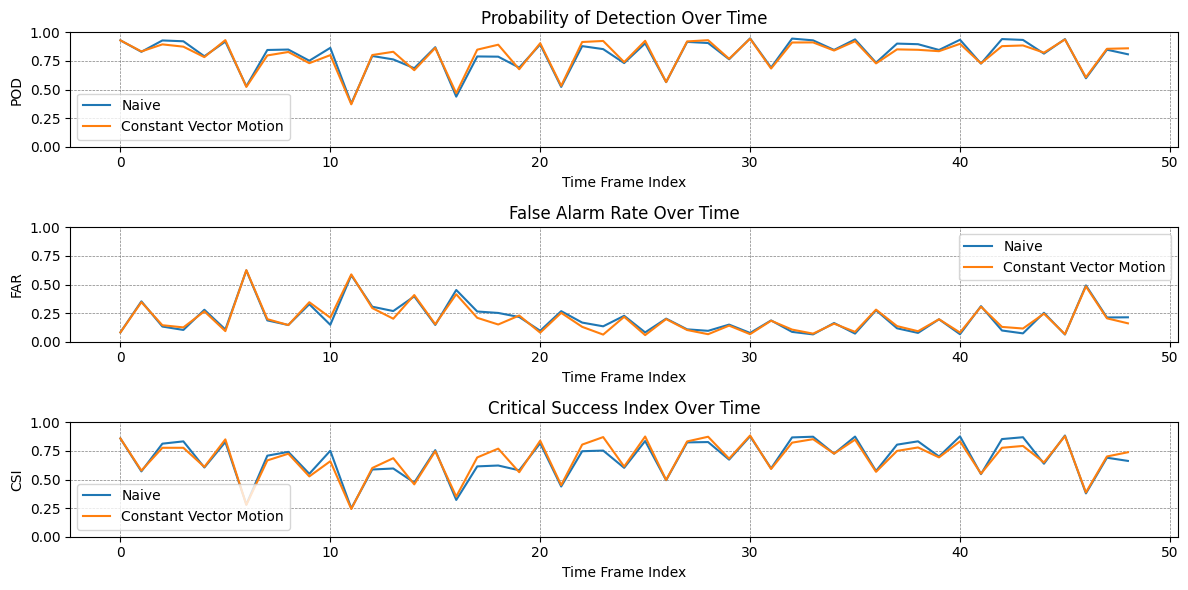

In [155]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation

In [156]:
def forecast_evaluation(lead_time: int, train_len: int = 10):
    pod_scores = []
    csi_scores = []
    far_scores = []
    leading_times = []

    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    for train_idx in tqdm(time_list, total=len(time_list)):
        test_idx = train_idx + lead_time

        prev_storms_map = storms_map_time_lst[train_idx-1]
        curr_storms_map = storms_map_time_lst[test_idx]

        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0

        tracker = SimpleTracker(max_velocity=MAX_VELOCITY, max_velocity_diff=MAX_VELOCITY_DIFF)
        tracker.fit(storms_map_time_lst[train_idx-train_len:train_idx], 
                    max_disparity_score=MAX_COST, test=False)

        pred_storms_map = StormsMap([
                tracker.tracker.forecast(storm.id, dt)
                for storm in prev_storms_map.storms 
            ], time_frame=curr_storms_map.time_frame)

        pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
        csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
        far_scores.append(far_score(pred_storms_map, curr_storms_map))
        leading_times.append(dt * 60)  # convert to minutes

    forecast_leads_df = pd.DataFrame({
        'predict_time': [storms_map_time_lst[i+lead_time].time_frame for i in time_list],
        'POD': pod_scores,
        'FAR': far_scores,
        'CSI': csi_scores,
        'leading_time (min)': leading_times
    })

    output_dir = f'output/{data_name}/{lead_time}_frame_leads'
    os.makedirs(output_dir, exist_ok=True)

    forecast_leads_df.to_csv(f'{output_dir}/ATA.csv', index=False)
    print(f"Store file successfully to {output_dir}/ATA.csv")

    return forecast_leads_df

### 4.1 3-frames leads

In [157]:
forecast_leads_df = forecast_evaluation(lead_time=3, train_len=10)

forecast_leads_df

100%|██████████| 37/37 [00:31<00:00,  1.17it/s]

Store file successfully to output/philippines_13.269_123.832/3_frame_leads/ATA.csv


,predict_time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:28:47,0.344047,0.703078,0.189592,24.016667
1,2025-01-08 04:34:48,0.332870,0.693935,0.189701,24.016667
2,2025-01-08 04:40:48,0.282601,0.767489,0.146211,24.016667
3,2025-01-08 04:46:48,0.539506,0.593232,0.301936,24.016667
4,2025-01-08 04:52:48,0.406047,0.574621,0.262219,24.016667
5,2025-01-08 04:58:49,0.381061,0.610039,0.238743,24.016667
6,2025-01-08 05:04:49,0.463298,0.483636,0.323096,24.016667
7,2025-01-08 05:10:49,0.498704,0.373138,0.384550,24.016667
8,2025-01-08 05:16:49,0.618951,0.369695,0.454097,24.016667
9,2025-01-08 05:22:50,0.451262,0.305105,0.376638,24.016667


### 4.2 5-frames leads

In [158]:
forecast_leads_df = forecast_evaluation(lead_time=5, train_len=10)

forecast_leads_df

100%|██████████| 35/35 [00:23<00:00,  1.49it/s]

Store file successfully to output/philippines_13.269_123.832/5_frame_leads/ATA.csv


,predict_time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:40:48,0.226145,0.836015,0.105041,36.033333
1,2025-01-08 04:46:48,0.266963,0.786542,0.134579,36.016667
2,2025-01-08 04:52:48,0.194668,0.802173,0.108792,36.016667
3,2025-01-08 04:58:49,0.288155,0.743158,0.157139,36.033333
4,2025-01-08 05:04:49,0.406881,0.619529,0.244735,36.033333
5,2025-01-08 05:10:49,0.364345,0.594175,0.237599,36.016667
6,2025-01-08 05:16:49,0.441752,0.434769,0.329717,36.016667
7,2025-01-08 05:22:50,0.320610,0.428442,0.258488,36.033333
8,2025-01-08 05:28:50,0.442903,0.397279,0.342821,36.033333
9,2025-01-08 05:34:50,0.448701,0.333741,0.366358,36.016667
